<a target="_blank" href="https://colab.research.google.com/github/opensim-org/opensim-core/blob/main/Bindings/Python/tutorials/Tutorial%205%20-%20Scaling%2C%20Inverse%20Kinematics%2C%20and%20Inverse%20Dynamics.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# 5. Scaling, Inverse Kinematics, and Inverse Dynamics


## 5.1. Objectives

**Purpose**

The purpose of this tutorial is to demonstrate how [OpenSim](https://opensim.stanford.edu/) [[1]](https://doi.org/10.1109/TBME.2007.901024) can be used to scale a model, and then solve the Inverse Kinematics (IK) and Inverse Dynamics (ID) problems using experimental data. 

To diagnose movement disorders and study human movement, biomechanists frequently ask human subjects to perform movements in a motion capture laboratory and use computational tools to analyze these movements. A common step in analyzing a movement is to compute the joint angles and joint moments of the subject during movement. OpenSim has tools for computing these quantities:

*   **Inverse Kinematics (IK)** is used to compute joint angles.
*   **Inverse Dynamics (ID)** is used to compute net joint reaction forces and net joint moments.



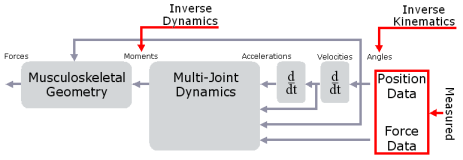



Inverse Kinematics computes the joint angles for a musculoskeletal model that best reproduce the motion of a subject. Inverse Dynamics then uses joint angles, angular velocities, and angular accelerations of the model, together with the experimental ground reaction forces and moments, to solve for the net reaction forces and net moments at each of the joints. The schematic above shows an overview of the inverse kinematics and inverse dynamics problems.

In this tutorial, you will:

*   Become familiar with OpenSim's Scale, Inverse Kinematics and Inverse Dynamics tools.
*   Solve an Inverse Kinematics and an Inverse Dynamics problem using experimental data.
*   Investigate the dynamic inconsistencies that arise during Inverse Dynamics.

**Format**

Each section of the tutorial guides you through certain tools within OpenSim and asks you to answer a few questions. The questions can be answered based on information from OpenSim and basic knowledge of the human musculoskeletal system. As you complete each section of the tutorial, feel free to explore OpenSim and the lower extremity model further on your own.

**Resources**

All of the files necessary to complete this tutorial are available in the following Google Drive folder: https://drive.google.com/drive/folders/1txjRDKPETE1NpOwzv0pSdIiCoc8aIZTf?usp=sharing

While you complete the tutorial, you will find cells that automatically download the required files.

To obtain a link to one of the files in Google Drive, right-click over it and click on **Get Link**.

**Local Installation**

You may also run this notebook using a locally installed OpenSim `conda` package. Visit [the OpenSim python scripting Confluence page](https://opensimconfluence.atlassian.net/wiki/spaces/OpenSim/pages/53085346/Scripting+in+Python) for more information on how to install OpenSim in a local Python environment. You will also need to download the resources from Google Drive to the same directory as this notebook. Then, you may skip to Section 5.3 below.

## 5.2. Set up Conda and OpenSim

First, set up the environment by executing the following cell (See [Tutorial 1: Introduction to OpenSim in Colab](https://colab.research.google.com/github/opensim-org/opensim-core/blob/main/Bindings/Python/tutorials/Tutorial%201%20-%20Introduction%20to%20OpenSim.ipynb) for more information).

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

Don't worry if after executing the previous cell you get an error saying that your session has failed. This happens because `condacolab` needs to restart the session for the changes to take effect. Therefore, you have to execute the previous cell before executing any other cell.

Now, execute the following cell to install the OpenSim `conda` package.

In [ ]:
!conda install opensim-org::opensim

## 5.3. Scaling a Musculoskeletal Model

In this tutorial, you will usea generic musculoskeletal model with 23 degrees of freedom and actuated by 54 muscles, named _3DGaitModel2354_ [[2]](https://doi.org/10.1109/10.102791) [[3]](https://doi.org/10.1080/10255849908907988). Detailed information about the model can found on the [Gait2392 and 2354 Models](https://simtk-confluence.stanford.edu:8443/display/OpenSim/Gait+2392+and+2354+Models) OpenSim documentation page hosted on Confluence.

Subject-specific modeling involves the following steps:
*  **Scaling** a generic musculoskeletal model to modify the body scale factors of the generic model so that it matches the anthropometry of a particular subject.
*  **Registering** the markers placed on the model to match the locations on the subject.

Scaling and registration have a significant effect on the solutions to the Inverse Kinematics and Inverse Dynamics problems, so it is crucial to perform these steps carefully.

A detailed explanation of the Scale Tool can be found on the [Scaling page](https://opensimconfluence.atlassian.net/wiki/spaces/OpenSim/pages/53090000/Scaling) of the documentation.

**Download Files**

First, let's download the model file (`gait2354_simbody.osim`). The file is stored in a Google Drive folder (See **Resources** in the Objectives section).

In [ ]:
!gdown "1roNo6te-wyNk-4UPqfmV7SmUfef4Bfq3&confirm=t" # gait2354_simbody.osim

Load the model into OpenSim. To test that the file has been downloaded correctly, let's print its name.

In [ ]:
import opensim as osim

# Load the model.
gait2354 = osim.Model('gait2354_simbody.osim')
print("Name of the model:", gait2354.getName())

To scale the model, we are going to use a configuration file (`gait2354_Setup_Scale.xml`). This Scale Setup file is an XML file that contains pre-configured settings to scale and register the generic gait2354 musculoskeletal model to the dimensions of a subject for which we have experimental data. A detailed explanation of the Scale Tool can be found on the [Scaling](https://simtk-confluence.stanford.edu:8443/display/OpenSim/Scaling) page of the documentation. The following cell downloads the file. The file is stored in a Google Drive folder (See **Resources** in the Objectives section).

In [ ]:
!gdown "1c0P8cN1zUmVFJxqvcpHZEDacyAoa6lQy&confirm=t" # gait2354_Setup_Scale.xml

We also need to download the MarketSet file (`gait2354_Scale_MarkerSet.xml`), which defines the position of the markers used when capturing experimental data. The file is stored in a Google Drive folder (See **Resources** in the Objectives section).

In [ ]:
!gdown "1VNDVGM-MKVrYs9w3aTPCLHOfwK-s2Nn8&confirm=t" # gait2354_Scale_MarkerSet.xml

Finally, we need a marker file (`subject01_static.trc`) which provides information about the position of the markers during the *static trial*, which is a trial in a known pose and not moving and is a typical trial used for the scaling step. In this case, we download a file with information of the user in a static pose. The file is stored in a Google Drive folder (See **Resources** in the Objectives section).

In [ ]:
!gdown "19-ouxBQN-XUOJ-K8lRe16DUs8fqaN1Yz&confirm=t" # subject01_static.trc

**Create Scale Tool**

The Scale Tool helps us scale the model. We can pass a configuration file as a parameter (`gait2354_Setup_Scale.xml`).

In [ ]:
# Create a ScaleTool object using the configuration file.
scale_tool = osim.ScaleTool('gait2354_Setup_Scale.xml')

# Print some information of the config file to test everything is correct.
print("Name:", scale_tool.getName())
print("Subject Mass:", scale_tool.getSubjectMass())
print("Subject Height:", scale_tool.getSubjectHeight())
print("Notes:", scale_tool.getPropertyByName("notes").toString())
print()

# Get model marker file name.
generic_model_maker = scale_tool.getGenericModelMaker()
print("Marker Set File Name:", generic_model_maker.getMarkerSetFileName())
print()

# Get marker file name.
marker_placer = scale_tool.getMarkerPlacer()
print("Marker Placer File Name:", marker_placer.getMarkerFileName())

**Perform Scaling**

Finally, we can scale the model by running the scale tool. You can visualize the resulting model (`subject01_simbody.osim`) in [OpenSim GUI](https://simtk.org/frs/index.php?group_id=91).

In [ ]:
# Run Scale Tool.
scale_tool.run()

**Questions:**

1. What is the mass of the generic musculoskeletal model? What was the mass of the subject? _Hint: Look for it in the `gait2354_simbody.osim` and `gait2354_Setup_Scale.xml` files._

2. What frequency was the experimental motion data captured?
_Hint: Look for it in the `subject01_static.trc` file._

3. Which body segments were scaled manually? _Hint: Look for it in the `gait2354_Setup_scale.xml` file._

## 5.4. Inverse Kinematics

Kinematics is the study of motion without considering the forces and moments that produce that motion [[4]](https://onlinelibrary.wiley.com/doi/book/10.1002/9780470549148). The purpose of Inverse Kinematics (IK) is to estimate the joint angles of a particular subject from experimental data. In this section, you will estimate a subject's joint angles during walking by performing an IK analysis using the subject scaled model and experimentally collected walking data. 

For each time step of recorded motion data, IK computes a set of joint angles that put the model in a configuration that "best matches" the experimental kinematics. OpenSim determines this "best match" by solving a weighted least squares optimization problem with the goal of minimizing marker error. Marker error is defined as the distance between an experimental marker and the corresponding model marker. Each marker has an associated weighting value, specifying how strongly that marker's error term should be minimized in the least squares problem. For each time step, the `InverseKinematicsTool` solves for a vector of generalized coordinates (e.g., joint angles), $q$, that minimizes the weighted sum of marker errors, which is expressed as:

$\underset{q}{\text{min}}\Bigg[ \sum_{i \in \text{markers}}{w_i || x_i^{\text{exp}} - x_i(q) ||^2}^{}\Bigg] $

where $q$ is the vector of generalized coordinates (e.g., joint angles), $x_i^{\text{exp}}$ is the position of the experimental marker $i$, $x_i(q)$ is the position of the corresponding model marker $i$ (which depends on $q$), and $w_i$ is the weight associated with marker $i$. 

A detailed explanation of the `InverseKinematicsTool` can be found on the [Inverse Kinematics page](https://opensimconfluence.atlassian.net/wiki/spaces/OpenSim/pages/53090037/Inverse+Kinematics) of the documentation.

**Download the files**

First, let's download the setup file for the `InverseKinematicsTool`.

The first file to download is the XML setup file (`subject01_Setup_IK.xml`) for the IK tool. The file is stored in a Google Drive folder (See **Resources** in the Objectives section).

In [ ]:
!gdown "1z1YGOTZlTCA4jpjRFbz0FlEaen1bETou&confirm=t" # subject01_Setup_IK.xml

The second file is the marker file (`subject01_walk1.trc`), which provides information about the position of the markers during a motion trial. The file is stored in a Google Drive folder (See **Resources** in the Objectives section).

In [ ]:
!gdown "10TVRHRNJNy766Zbejjv05n3SKh0B80qD&confirm=t" # subject01_walk1.trc

**Create the `InverseKinematicsTool`**

The `InverseKinematicsTool` helps us solve the Inverse Kinematics problem. We can pass a configuration file as a parameter (`subject01_Setup_IK.xml`).

In [ ]:
# Create an IK object using the configuration file.
inverse_kinematics_tool = osim.InverseKinematicsTool('subject01_Setup_IK.xml')

# Print some information of the config file to check that everything is correct.
print("Name:", inverse_kinematics_tool.getName())
print("Model File:", inverse_kinematics_tool.get_model_file())
print("Marker File:", inverse_kinematics_tool.get_marker_file())
print("Accuracy:", inverse_kinematics_tool.get_accuracy())
print("Time Range: [", inverse_kinematics_tool.get_time_range(0), ",", inverse_kinematics_tool.get_time_range(1), "]")
print("Constraint Weight:", inverse_kinematics_tool.get_constraint_weight())
print()

# Print weights information
print("Weights:")
task_set = inverse_kinematics_tool.get_IKTaskSet()
for i in range(task_set.getSize()):
    task = task_set.get(i)
    print(task.getName())
    print(task.getWeight())
    print()

**Perform Inverse Kinematics**

Finally, we run the IK tool. You can visualize the resulting motion file (`subject01_walk1_ik.mot`) by associating it to the scaled model (`subject01_simbody.osim`) in the [OpenSim GUI](https://simtk.org/frs/index.php?group_id=91).

In [ ]:
inverse_kinematics_tool.run()

**Visualize the marker errors**

The output file `subject01_ik_marker_errors.sto` provides the markers errors associated with each frame of the generated motion. You can parse this file using a `TableProcessor` and visualize the error obtained per frame.

In [ ]:
# Use the TableProcessor to read the motion file.
table = osim.TableProcessor("subject01_ik_marker_errors.sto")
# Process the file.
tableErrors = table.process()
# Print labels for each column.
print(tableErrors.getColumnLabels())

We will plot the total squared error, the RMS error for the markers, and the maximum error for the markers. In the next cell you will extract this information from the motion file.


In [ ]:
# Get columns we want to plot, and the independent column (Time).
total_squared_error = tableErrors.getDependentColumn('total_squared_error')
marker_error_RMS = tableErrors.getDependentColumn('marker_error_RMS')
marker_error_max = tableErrors.getDependentColumn('marker_error_max')
x_time = tableErrors.getIndependentColumn()

Now, we can plot the error.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create six subplots, with 2 rows and 3 columns.
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
fig.suptitle('Marker Errors from Inverse Kinematics', fontsize=16)

# Plot the knee angles on the first subplot.
axs.plot(x_time, total_squared_error.to_numpy(), label='total_squared_error')
axs.plot(x_time, marker_error_RMS.to_numpy(), label='marker_error_RMS')
axs.plot(x_time, marker_error_max.to_numpy(), label='marker_error_max')
axs.set_xlabel('Time (s)')
axs.set_ylabel('Marker Error (m)')
axs.grid()
axs.legend()

# Set the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

**Questions:**

4. Which markers have weighting values less than one? Why?
*Hint: Think about joints that have not been modeled.*

5. What is the root-mean-squared (RMS) error of all the markers in the last frame of the motion? Include units. Does this seem reasonable? Explain.

6. What was the value of the maximum marker error in the last frame? Include units. Which marker had this maximum error, and why?
*Hint: Think about the weighted least squares problem.*

## 5.5. Inverse Dynamics

Dynamics is the study of motion and the forces and moments that produce that motion [[4]](https://onlinelibrary.wiley.com/doi/book/10.1002/9780470549148). The purpose of Inverse Dynamics is to estimate the forces and moments that cause a particular motion, and its results can be used to infer how muscles are utilized in that motion. To determine these forces and moments, equations of motion for the system are solved iteratively [[5]](https://doi.org/10.1115/1.2834295). The equations of motion are derived using the kinematic description and mass properties of a musculoskeletal model. Then, using the joint angles from Inverse Kinematics and experimental ground reaction force data, the net reaction forces and net moments at each of the joints are calculated such that the dynamic equilibrium conditions and boundary conditions are satisfied [[5]](https://doi.org/10.1115/1.2834295).  

A detailed explanation of the `InverseDynamicsTool` can be found on the [Inverse Dynamics page](https://opensimconfluence.atlassian.net/wiki/spaces/OpenSim/pages/53090074/Inverse+Dynamics) of the OpenSim documentation hosted on confluence.

**Download the files**

First, let's download the configuration file (`subject01_Setup_InverseDynamics.xml`) for the `InverseDynamicsTool`. The file is stored in a Google Drive folder (See **Resources** in the Objectives section).

In [ ]:
!gdown "1aE_GIV0dNepL6oUGJalznsJQZDlSfcet&confirm=t" # subject01_Setup_InverseDynamics.xml

The second file is a external loads file (`subject01_walk1_grf.xml`), that contains the external loads applied to the model. The file is stored in a Google Drive folder (See **Resources** in the Objectives section).

In [ ]:
!gdown "1OZtWIpJ1UH2uViiEEeRluwfi54wsgIqG&confirm=t" # subject01_walk1_grf.xml

The third file is a coordinates file (`subject01_walk1_grf.mot`), containing coordinate data. The file is stored in a Google Drive folder (See **Resources** in the Objectives section).

In [ ]:
!gdown "18L9Nj9ff-2evQkiXqD2KDZXu3DWZ30vh&confirm=t" # subject01_walk1_grf.mot

**Create the `InverseDynamicsTool`**

The `InverseDynamicsTool` helps us perform Inverse Dynamics. We can pass a configuration file as a parameter (`subject01_Setup_InverseDynamics.xml`).

In [ ]:
# Create an ID object using the configuration file.
inverse_dynamics_tool = osim.InverseDynamicsTool('subject01_Setup_InverseDynamics.xml')

# Print some information of the config file to check that everything is correct.
print("Name:", inverse_dynamics_tool.getName())
print("Model File:", inverse_dynamics_tool.getModelFileName())
print("External Loads File:", inverse_dynamics_tool.getExternalLoadsFileName())
print("Coordinates File:", inverse_dynamics_tool.getCoordinatesFileName())
print("Time Range: [", inverse_dynamics_tool.getStartTime(), ",", inverse_dynamics_tool.getEndTime(), "]")
print("Lowpass Cutoff Frequency:", inverse_dynamics_tool.getLowpassCutoffFrequency())

**Run Inverse Dynamics**

Finally, we can run Inverse Dynamics by running the `InverseDynamicsTool`.

In [ ]:
inverse_dynamics_tool.run()

**Visualize the Inverse Dynamics results**

After running the Inverse Dynamics Tool, a file named `inverse_dynamics.sto` is generated. This file contains the results of the Inverse Dynamics execution, and you can parse it using a `TimeSeriesTable` to visualize the results.

In [ ]:
# Load the inverse dynamics results into a TimeSeriesTable.
tableID = osim.TimeSeriesTable("ResultsInverseDynamics/inverse_dynamics.sto")

# Print labels for each column.
print(tableID.getColumnLabels())

We are going to compare the moments of the ankle angle of both legs, so let's extract these quantities from the Inverse Dynamics results.

In [ ]:
# Get columns we want to represent, and the independent column (Time).
ankle_angle_r_moment = tableID.getDependentColumn('ankle_angle_r_moment')
ankle_angle_l_moment = tableID.getDependentColumn('ankle_angle_l_moment')
x_time = tableID.getIndependentColumn()

Now, we can plot the moments.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create six subplots, with 2 rows and 3 columns.
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
fig.suptitle('Ankle Angle Moment Comparison')

# Plot the knee angles on the first subplot.
axs.plot(x_time, ankle_angle_r_moment.to_numpy(), label='ankle_angle_r_moment')
axs.plot(x_time, ankle_angle_l_moment.to_numpy(), label='ankle_angle_l_moment')
axs.set_xlabel('Time (s)')
axs.set_ylabel('Moment (N-m)')
axs.grid()
axs.legend()

# Set the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

In solving the Inverse Dynamics problem, both kinematic data and force plate data were used, making this an over-determined problem. In other words, the problem has more equations than unknowns (i.e., degrees of freedom). Due to errors in the experimental motion data and inaccuracies in the musculoskeletal model, it turns out that Newton's second law is violated, or $\overrightarrow{F}_{\text{exp}} \neq m * \overrightarrow{a}$ [[5]](https://doi.org/10.1115/1.2834295). One method to handle this inconsistency is to compute and apply residual forces and moments to a particular body segment in the model, such that Newton's second law becomes:

$\overrightarrow{F}_{\text{exp}} + \overrightarrow{F}_{\text{residual}} = m * \overrightarrow{a} $

Note: An analogous equation relates the ground reaction moment, $\overrightarrow{M}_{\text{exp}}$ to the residual moment, $\overrightarrow{M}_{\text{residual}}$.

In this musculoskeletal model, the residuals are applied to the pelvis segment. To see the residuals from the inverse dynamics solution, plot `pelvis_tx_force`, `pelvis_ty_force`, and `pelvis_tz_force` versus `time`. Using this plot, answer question 9.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get columns we want to represent, and the independent column (Time).
pelvis_tx_force = tableID.getDependentColumn('pelvis_tx_force')
pelvis_ty_force = tableID.getDependentColumn('pelvis_ty_force')
pelvis_tz_force = tableID.getDependentColumn('pelvis_tz_force')
x_time = tableID.getIndependentColumn()

# Create six subplots, with 2 rows and 3 columns.
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
fig.suptitle('Pelvis Force Residuals')

# Plot the knee angles on the first subplot.
axs.plot(x_time, pelvis_tx_force.to_numpy(), label='pelvis_tx_force')
axs.plot(x_time, pelvis_ty_force.to_numpy(), label='pelvis_ty_force')
axs.plot(x_time, pelvis_tz_force.to_numpy(), label='pelvis_tz_force')
axs.set_xlabel('Time')
axs.set_ylabel('Force')
axs.grid()
axs.legend()

# Set the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

**Questions:**

7. On your plot of the ankle moments, identify when heel strike, stance phase, toe off, and swing phase occur for each curve (i.e., left leg and right leg).

8. Based on your plot and the angle convention for the ankle, give an explanation of what is happening at the ankle just before toe-off.
*Hint: It may be useful to visualize the motion in the OpenSim GUI and use the Coordinate sliders to understand the angle convention for the ankle.*

9. What are the maximum magnitudes of the residual forces? Using the mass of the subject from Question 1, what fraction of body weight are the maximum residual forces?

While applying residual forces and moments makes the model's motion dynamically consistent with the external forces, this strategy is undesirable because the residuals can be large. More advanced strategies have been developed to deal with the problem of residuals and dynamic inconsistencies, such as least-squares optimization [[5]](https://doi.org/10.1115/1.2834295), the Residual Elimination Algorithm (REA) [[6]](https://doi.org/10.1016/j.jbiomech.2005.02.010), and the Residual Reduction Algorithm (RRA) [[7]](https://bcats.stanford.edu/previous_bcats/bcats06/pdf/BCATS_2006_abstract_book.pdf#page=31). OpenSim implements a Residual Reduction Algorithm as part of its workflow for generating muscle-actuated simulations [[7]](https://bcats.stanford.edu/previous_bcats/bcats06/pdf/BCATS_2006_abstract_book.pdf#page=31). A detailed explanation of the Residual Reduction Algorithm (RRA) can be found on the Residual Reduction Algorithm page of the documentation. For additional information on these strategies, please also see [[1]](https://doi.org/10.1080/10255842.2011.627560), [[5]](https://doi.org/10.1115/1.2834295), [[6]](https://doi.org/10.1016/j.jbiomech.2005.02.010) and [[7]](https://bcats.stanford.edu/previous_bcats/bcats06/pdf/BCATS_2006_abstract_book.pdf#page=31).

## 5.6. Conclusion

In this tutorial, you scaled a musculoskeletal model and used it to perform Inverse Kinematics and Inverse Dynamics. Then, you explored the results of each analyses.

## 5.7. Useful Links





> **OpenSim Website:** https://opensim.stanford.edu/
>
> **OpenSim Python Scripting:** https://opensimconfluence.atlassian.net/wiki/spaces/OpenSim/pages/53085346/Scripting+in+Python
>
> **OpenSim API Documentation:** https://simtk.org/api_docs/opensim/api_docs/
> 
> **OpenSim Creator Website:** https://opensimcreator.com/
> 
> **SimTK Website:** https://simtk.org/projects/opensim
> 
> **Biomechanics of Movement's Course:** https://www.youtube.com/channel/UCDNGy0KKNLQ-ztcL5h2Z6zA
>
> **Webinar on Scaling and Inverse Kinematics in OpenSim:** https://www.youtube.com/watch?v=ZG7wzvQC6eU

## 5.8. Acknowledgments

The experimental gait data were collected by Jill Higginson and Chand John in the Neuromuscular Biomechanics Lab at the University of Delaware [[8]](https://doi.org/10.1080/10255842.2011.627560). The data include marker trajectories and ground reaction forces for an adult male walking at a self-selected speed on an instrumented split-belt treadmill. Please note that the data distributed with OpenSim is from a different subject than the one described in the paper. Data collection protocols were the same for both subjects.

Thanks to [OpenSimColab](https://simtk.org/projects/opencolab) project [[9]](https://doi.org/10.1080/10255842.2022.2104607) for creating the first OpenSim Conda package.

## 5.9. References


> [1].   Delp, S. L., Anderson, F. C., Arnold, A. S., Loan, P., Habib, A., John, C. T., Guendelman, E., & Thelen, D. G. (2007). **OpenSim: open-source software to create and analyze dynamic simulations of movement.** *IEEE Transactions on Bio-Medical Engineering*, 54(11), 1940–1950. https://doi.org/10.1109/TBME.2007.901024
> 
> [2].   Delp, S. L., Loan, J. P., Hoy, M. G., Zajac, F. E., Topp, E. L., & Rosen, J. M. (1990). **An interactive graphics-based model of the lower extremity to study orthopaedic surgical procedures.** *IEEE Transactions on Bio-Medical Engineering*, 37(8), 757–767. https://doi.org/10.1109/10.102791
>
> [3]. Anderson, F. C., & Pandy, M. G. (1999). **A dynamic optimization solution for vertical jumping in three dimensions.** *Computer Methods in Biomechanics and Biomedical Engineering*, 2(3), 201–231. https://doi.org/10.1080/10255849908907988
>
> [4]. Winter, D. A. (1990). **The biomechanics and motor control of human movement** (2a ed.). *John Wiley & Sons*. https://onlinelibrary.wiley.com/doi/book/10.1002/9780470549148
>
> [5]. Kuo, A. D. (1998). **A least-squares estimation approach to improving the precision of inverse dynamics computations.** *Journal of Biomechanical Engineering*, 120(1), 148–159. https://doi.org/10.1115/1.2834295
>
> [6]. Thelen, D. G., & Anderson, F. C. (2006). **Using computed muscle control to generate forward dynamic simulations of human walking from experimental data.** *Journal of Biomechanics*, 39(6), 1107–1115. https://doi.org/10.1016/j.jbiomech.2005.02.010
>
> [7]. John, C.T., Anderson, F.C., Guendelman, E., Arnold, A.S., Delp, S.L. (21st October 2006). **An algorithm for generating muscle-actuated simulations of long-duration movements.** *Biomedical Computation at Stanford (BCATS) Symposium*, Stanford University, Poster Presentation. https://bcats.stanford.edu/previous_bcats/bcats06/pdf/BCATS_2006_abstract_book.pdf#page=31
>
> [8]. John, C. T., Anderson, F. C., Higginson, J. S., & Delp, S. L. (2013). **Stabilisation of walking by intrinsic muscle properties revealed in a three-dimensional muscle-driven simulation.** *Computer Methods in Biomechanics and Biomedical Engineering*, 16(4), 451–462. https://doi.org/10.1080/10255842.2011.627560
>
> [9] Mokhtarzadeh, H., Jiang, F., Zhao, S., & Malekipour, F. (2022). **OpenColab project: OpenSim in Google colaboratory to explore biomechanics on the web.** *Computer Methods in Biomechanics and Biomedical Engineering*, 1–9. https://doi.org/10.1080/10255842.2022.2104607